In [1]:
#Load the necessary libraries.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os, sys
import itertools


pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns', None)
warnings.filterwarnings('ignore',)


Objectve = Sales forecast using time series

In [2]:
df1 = pd.read_csv('../amazon.csv')

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

In [3]:
df1.tail()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
1460,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,₹379,₹919,59%,4,"1,090",SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,"AHITFY6AHALOFOHOZEOC6XBP4FEA,AFRABBODZJZQB6Z4U...","Prabha ds,Raghuram bk,Real Deal,Amazon Custome...","R3G3XFHPBFF0E8,R3C0BZCD32EIGW,R2EBVBCN9QPD9R,R...","Received the product without spanner,Excellent...","I received product without spanner,Excellent p...",https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...
1461,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,"₹2,280","₹3,045",25%,4.1,"4,118","230 Volts, 400 watts, 1 Year","AFG5FM3NEMOL6BNFRV2NK5FNJCHQ,AGEINTRN6Z563RMLH...","Manu Bhai,Naveenpittu,Evatira Sangma,JAGANNADH...","R3DDL2UPKQ2CK9,R2SYYU1OATVIU5,R1VM993161IYRW,R...","ok,everything was good couldn't return bcoz I ...","ok,got everything as mentioned but the measuri...",https://m.media-amazon.com/images/I/41gzDxk4+k...,https://www.amazon.in/Prestige-Delight-PRWO-1-...
1462,B009P2LIL4,Bajaj Majesty RX10 2000 Watts Heat Convector R...,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...","₹2,219","₹3,080",28%,3.6,468,International design and styling|Two heat sett...,"AGVPWCMAHYQWJOQKMUJN4DW3KM5Q,AF4Q3E66MY4SR7YQZ...","Nehal Desai,Danish Parwez,Amazon Customer,Amaz...","R1TLRJVW4STY5I,R2O455KRN493R1,R3Q5MVGBRIAS2G,R...","very good,Work but front melt after 2 month,Go...","plastic but cool body ,u have to find sturdy s...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Bajaj-RX-10-2000-Watt-Co...
1463,B00J5DYCCA,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,"Home&Kitchen|Heating,Cooling&AirQuality|Fans|E...","₹1,399","₹1,890",26%,4,"8,031",Fan sweep area: 230 MM ; Noise level: (40 - 45...,"AF2JQCLSCY3QJATWUNNHUSVUPNQQ,AFDMLUXC5LS5RXDJS...","Shubham Dubey,E.GURUBARAN,Mayank S.,eusuf khan...","R39Q2Y79MM9SWK,R3079BG1NIH6MB,R29A31ZELTZNJM,R...","Fan Speed is slow,Good quality,Good product,go...",I have installed this in my kitchen working fi...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Havells-Ventilair-230mm-...
1464,B01486F4G6,Borosil Jumbo 1000-Watt Grill Sandwich Maker (...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,"₹2,863","₹3,690",22%,4.3,"6,987","Brand-Borosil, Specification â€“ 23V ~ 5Hz;1 W...","AFGW5PT3R6ZAVQR4Y5MWVAKBZAYA,AG7QNJ2SCS5VS5VYY...","Rajib,Ajay B,Vikas Kahol,PARDEEP,Anindya Prama...","R20RBRZ0WEUJT9,ROKIFK9R2ISSE,R30EEG2FNJSN5I,R2...","Works perfect,Ok good product,Nice Product. Re...",It does it job perfectly..only issue is temp c...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Borosil-Jumbo-1000-Watt-...


**Data Wrangling**

In [4]:
df1.columns

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')

In [5]:
df1[['rating','rating_count']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   rating        1465 non-null   object
 1   rating_count  1463 non-null   object
dtypes: object(2)
memory usage: 23.0+ KB


In [6]:
df1.isna().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [7]:
# Apply the Data_cleaning script

sys.path.append('../src')
from Data_cleaning import DataHandling

cleaner = DataHandling(df1)

cleaner.apply_cleaning()

df_cleaned = cleaner.get_cleaned_dataframe()

df_cleaned.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,399.0,1099.0,64.0,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,199.0,349.0,43.0,4.0,43994.0,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,199.0,1899.0,90.0,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,329.0,699.0,53.0,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,154.0,399.0,61.0,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [8]:
#Handle missing values using SimpleImputer
from sklearn.impute import SimpleImputer

Imputer = SimpleImputer(strategy='most_frequent')


df1[['rating','rating_count']] = Imputer.fit_transform(df1[['rating','rating_count']])

df1[['rating','rating_count']].isna().sum()

rating          0
rating_count    0
dtype: int64

In [9]:
# check missing values
df1.isna().sum()


product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [10]:
# rename columns
new_column_name = {
    'discounted_price':'discounted_price_$',
    'actual_price':'actual_price_$',
    'discount_percentage':'discount_percentage_%',
    'product_id':'product_id',
    'product_name':'product_name', 
    'category':'category',       
    'discounted_price_$':'discounted_price_$',   
    'actual_price_$':'actual_price_$',       
    'discount_percentage_%':'discount_percentage_%',
    'rating':'rating',               
    'rating_count':'rating_count',        
    'about_product':'about_product',        
    'user_id':'user_id',              
    'user_name':'user_name',            
    'review_id':'review_id',            
    'review_title':'review_title',         
    'review_content':'review_content',       
    'img_link':'img_link',             
    'product_link':'product_link',
}

df1.rename(columns=new_column_name, inplace=True)

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             1465 non-null   object 
 1   product_name           1465 non-null   object 
 2   category               1465 non-null   object 
 3   discounted_price_$     1465 non-null   float64
 4   actual_price_$         1465 non-null   float64
 5   discount_percentage_%  1465 non-null   float64
 6   rating                 1465 non-null   float64
 7   rating_count           1465 non-null   float64
 8   about_product          1465 non-null   object 
 9   user_id                1465 non-null   object 
 10  user_name              1465 non-null   object 
 11  review_id              1465 non-null   object 
 12  review_title           1465 non-null   object 
 13  review_content         1465 non-null   object 
 14  img_link               1465 non-null   object 
 15  prod

In [12]:
#Cleaning categorical columns

df1.select_dtypes(include='object').nunique()

product_id        1351
product_name      1337
category           211
about_product     1293
user_id           1194
user_name         1194
review_id         1194
review_title      1194
review_content    1212
img_link          1412
product_link      1465
dtype: int64

**Descriptive Statistics**

In [13]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

**Numerical Attributes**

In [14]:
# Numerical Attributes
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
discounted_price_$,1465.0,3125.310874,6944.304394,39.0,325.0,799.0,1999.0,77990.0,77951.0,2.221956,4.452395,25.643590
actual_price_$,1465.0,5444.990635,10874.826864,39.0,800.0,1650.0,4295.0,139900.0,139861.0,1.997217,4.559879,29.723082
discount_percentage_%,1465.0,47.691468,21.635905,0.0,32.0,50.0,63.0,94.0,94.0,0.453664,-0.290532,-0.580729
rating,1465.0,4.096587,0.291574,2.0,4.0,4.1,4.3,5.0,3.0,0.071175,-1.243343,4.364576
rating_count,1465.0,18283.367235,42725.921124,2.0,1191.0,5179.0,17325.0,426973.0,426971.0,2.336874,5.677990,40.412286


**Categorical Attributes**

In [15]:
# Categorical aatributes

cat_attributes.describe().T


,count,unique,top,freq
product_id,1465,1351,B07JW9H4J1,3
product_name,1465,1337,"Fire-Boltt Ninja Call Pro Plus 1.83"" Smart Wat...",5
category,1465,211,Computers&Accessories|Accessories&Peripherals|...,233
about_product,1465,1293,[CHARGE & SYNC FUNCTION]- This cable comes wit...,6
user_id,1465,1194,"AHIKJUDTVJ4T6DV6IUGFYZ5LXMPA,AE55KTFVNXYFD5FPY...",10
user_name,1465,1194,"$@|\|TO$|-|,Sethu madhav,Akash Thakur,Burger P...",10
review_id,1465,1194,"R3F4T5TRYPTMIG,R3DQIEC603E7AY,R1O4Z15FD40PV5,R...",10
review_title,1465,1194,"Worked on iPhone 7 and didn’t work on XR,Good ...",10
review_content,1465,1212,"I am not big on camera usage, personally. I wa...",8
img_link,1465,1412,https://m.media-amazon.com/images/I/413sCRKobN...,3


In [16]:
df1.columns

Index(['product_id', 'product_name', 'category', 'discounted_price_$',
       'actual_price_$', 'discount_percentage_%', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')

In [17]:
cat_attributes.shape

(1465, 11)

In [18]:
#create an only categorical and numerical features dataframe
num_df = df1.select_dtypes(include='float')
cat_df = df1.select_dtypes(include='object')

In [19]:
num_df[:5]

,discounted_price_$,actual_price_$,discount_percentage_%,rating,rating_count
0,399.0,1099.0,64.0,4.2,24269.0
1,199.0,349.0,43.0,4.0,43994.0
2,199.0,1899.0,90.0,3.9,7928.0
3,329.0,699.0,53.0,4.2,94363.0
4,154.0,399.0,61.0,4.2,16905.0


**Cleaning text or categorical features**

In [20]:
#categorical dataframe
cat_df[:5]

,product_id,product_name,category,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


Category = '|', user_id to review_title = ',' # clean accordingly

In [21]:
sys.path.append('../src')
from Data_cleaning import CategoricalHandling

cat_cleaner = CategoricalHandling(cat_df)

df2_cleaned = cat_cleaner.apply_cat(lambda x: x.lower() if isinstance(x, str) else x, columns=['user_name'])

df2_cleaned[:5]

,product_id,product_name,category,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [22]:
df2_cleaned.shape

(1465, 11)

In [23]:

# splits and flatten the column based on the delimiter , or |
def split_and_flatten(column):
    split_values = column.str.split('[|,]', regex=True).to_list()
    flat_list = list(itertools.chain.from_iterable(split_values))
    return flat_list

#Pad the list to the same shape
def pad_list(lists):
    max_len = max(len(lst) for lst in lists)
    return [lst + [None] * (max_len - len(lst)) for lst in lists] 

In [24]:
# global dict to store processed data
flattened_data = {}
#take account of maximum length encountered
max_len = 0

for column in df2_cleaned.columns:
    flattened_column = split_and_flatten(df2_cleaned[column])
    flattened_data[column] = flattened_column
    max_len = max(max_len, len(flattened_column))
    
for key in flattened_data:
    while len(flattened_data[key]) < max_len:
        flattened_data[key].append(None)
    
flattened_data = pd.DataFrame(flattened_data)

for column in flattened_data.columns:
    if flattened_data[column].dtype == object:
        flattened_data[column].fillna('Missing', inplace=True)
    else:
        flattened_data[column].fillna(flattened_data[column].mode()[0], inplace=True)
        
        
flattened_data = flattened_data[~flattened_data.isin(['Missing']).any(axis=1)]


print(flattened_data[:3])

   product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG                                                 12   
2  B096MSW6CT                                                 11   

                  category                                   about_product  \
0    Computers&Accessories  High Compatibility : Compatible With iPhone 12   
1  Accessories&Peripherals                                              11   
2       Cables&Accessories                                     X/XsMax/Xr    

                        user_id     user_name       review_id  \
0  AG3D6O4STAQKAY2UVGEUV46KN35Q         Manav  R3HXWT0LRP0NMF   
1  AHMY5CWJMMK5BJRBBSNLYT3ONILA  Adarsh gupta  R2AJM3LFTLZHFO   
2  AHCTC6ULH4XB6YHDY6PCH2R772LQ       Sundeep    R6AQJGUP6P86   

              review_title                                  review_content  \
0                Satisfied  Looks durable Charging is fine tooNo complains 

In [25]:
flattened_data.head()

,product_id,product_name,category,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,High Compatibility : Compatible With iPhone 12,AG3D6O4STAQKAY2UVGEUV46KN35Q,Manav,R3HXWT0LRP0NMF,Satisfied,Looks durable Charging is fine tooNo complains,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,12,Accessories&Peripherals,11,AHMY5CWJMMK5BJRBBSNLYT3ONILA,Adarsh gupta,R2AJM3LFTLZHFO,Charging is really fast,Charging is really fast,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,11,Cables&Accessories,X/XsMax/Xr,AHCTC6ULH4XB6YHDY6PCH2R772LQ,Sundeep,R6AQJGUP6P86,Value for money,good product.,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,X,Cables,iPhone 8/8 Plus,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,S.Sayeed Ahmed,R1KD19VHEDV0OR,Product review,Till now satisfied with the quality.,https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,8,USBCables,iPhone 7/7 Plus,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,jaspreet singh,R3C02RMYQMK6FC,Good quality,This is a good product . The charging speed is...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [26]:
flattened_data.shape

(1465, 11)

In [27]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   discounted_price_$     1465 non-null   float64
 1   actual_price_$         1465 non-null   float64
 2   discount_percentage_%  1465 non-null   float64
 3   rating                 1465 non-null   float64
 4   rating_count           1465 non-null   float64
dtypes: float64(5)
memory usage: 57.4 KB


In [28]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   product_id      1465 non-null   object
 1   product_name    1465 non-null   object
 2   category        1465 non-null   object
 3   about_product   1465 non-null   object
 4   user_id         1465 non-null   object
 5   user_name       1465 non-null   object
 6   review_id       1465 non-null   object
 7   review_title    1465 non-null   object
 8   review_content  1465 non-null   object
 9   img_link        1465 non-null   object
 10  product_link    1465 non-null   object
dtypes: object(11)
memory usage: 126.0+ KB


In [29]:
#merge them together to create one dataframe by creating a new index.
num_df.reset_index(inplace=True)

flattened_data.reset_index(inplace=True)

df2 = pd.merge(num_df,flattened_data, left_on='index', right_on='index', how='outer')

df2.head()

,index,discounted_price_$,actual_price_$,discount_percentage_%,rating,rating_count,product_id,product_name,category,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,0,399.0,1099.0,64.0,4.2,24269.0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,High Compatibility : Compatible With iPhone 12,AG3D6O4STAQKAY2UVGEUV46KN35Q,Manav,R3HXWT0LRP0NMF,Satisfied,Looks durable Charging is fine tooNo complains,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,1,199.0,349.0,43.0,4.0,43994.0,B098NS6PVG,12,Accessories&Peripherals,11,AHMY5CWJMMK5BJRBBSNLYT3ONILA,Adarsh gupta,R2AJM3LFTLZHFO,Charging is really fast,Charging is really fast,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,2,199.0,1899.0,90.0,3.9,7928.0,B096MSW6CT,11,Cables&Accessories,X/XsMax/Xr,AHCTC6ULH4XB6YHDY6PCH2R772LQ,Sundeep,R6AQJGUP6P86,Value for money,good product.,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,3,329.0,699.0,53.0,4.2,94363.0,B08HDJ86NZ,X,Cables,iPhone 8/8 Plus,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,S.Sayeed Ahmed,R1KD19VHEDV0OR,Product review,Till now satisfied with the quality.,https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,4,154.0,399.0,61.0,4.2,16905.0,B08CF3B7N1,8,USBCables,iPhone 7/7 Plus,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,jaspreet singh,R3C02RMYQMK6FC,Good quality,This is a good product . The charging speed is...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [30]:

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1465 entries, 0 to 1464
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  1465 non-null   int64  
 1   discounted_price_$     1465 non-null   float64
 2   actual_price_$         1465 non-null   float64
 3   discount_percentage_%  1465 non-null   float64
 4   rating                 1465 non-null   float64
 5   rating_count           1465 non-null   float64
 6   product_id             1465 non-null   object 
 7   product_name           1465 non-null   object 
 8   category               1465 non-null   object 
 9   about_product          1465 non-null   object 
 10  user_id                1465 non-null   object 
 11  user_name              1465 non-null   object 
 12  review_id              1465 non-null   object 
 13  review_title           1465 non-null   object 
 14  review_content         1465 non-null   object 
 15  img_

In [31]:
#drop the index column and save the dataframe 
if 'index' in df2.columns:
    df2.drop(columns='index', inplace=True)
    
df2.reset_index(drop=True, inplace=True)

df2.to_csv('../data/amazon.csv', index=False)
print('New Dataframe saved as a csv file...')

New Dataframe saved as a csv file...


**Descriptive Statistical analysis on df2**

In [32]:
# This will only show numerical variables in the dataset.

df2.describe() 

,discounted_price_$,actual_price_$,discount_percentage_%,rating,rating_count
count,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000
mean,3125.310874,5444.990635,47.691468,4.096587,18283.367235
std,6944.304394,10874.826864,21.635905,0.291574,42725.921124
min,39.000000,39.000000,0.000000,2.000000,2.000000
25%,325.000000,800.000000,32.000000,4.000000,1191.000000
50%,799.000000,1650.000000,50.000000,4.100000,5179.000000
75%,1999.000000,4295.000000,63.000000,4.300000,17325.000000
max,77990.000000,139900.000000,94.000000,5.000000,426973.000000


In [33]:
#sort the dataset by their features

num_attributes = df2.select_dtypes(exclude='object')
cat_attributes = df2.select_dtypes(include='object')


**Numerical Attributes**

In [34]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()


describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
discounted_price_$,1465.0,3125.310874,6944.304394,39.0,325.0,799.0,1999.0,77990.0,77951.0,2.221956,4.452395,25.643590
actual_price_$,1465.0,5444.990635,10874.826864,39.0,800.0,1650.0,4295.0,139900.0,139861.0,1.997217,4.559879,29.723082
discount_percentage_%,1465.0,47.691468,21.635905,0.0,32.0,50.0,63.0,94.0,94.0,0.453664,-0.290532,-0.580729
rating,1465.0,4.096587,0.291574,2.0,4.0,4.1,4.3,5.0,3.0,0.071175,-1.243343,4.364576
rating_count,1465.0,18283.367235,42725.921124,2.0,1191.0,5179.0,17325.0,426973.0,426971.0,2.336874,5.677990,40.412286


**Categorical Attributes**

In [35]:
cat_attributes.describe().T

,count,unique,top,freq
product_id,1465,1351,B07JW9H4J1,3
product_name,1465,1049,Black),29
category,1465,36,Cables,168
about_product,1465,1045,gaming console,11
user_id,1465,1102,AG3D6O4STAQKAY2UVGEUV46KN35Q,5
user_name,1465,983,Amazon Customer,83
review_id,1465,1105,R3HXWT0LRP0NMF,5
review_title,1465,883,Good,85
review_content,1465,1020,Good,31
img_link,1465,1412,https://m.media-amazon.com/images/I/413sCRKobN...,3


## Business Analytics

In [36]:
df2.columns

Index(['discounted_price_$', 'actual_price_$', 'discount_percentage_%',
       'rating', 'rating_count', 'product_id', 'product_name', 'category',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')

In [37]:
df2.head()

,discounted_price_$,actual_price_$,discount_percentage_%,rating,rating_count,product_id,product_name,category,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,399.0,1099.0,64.0,4.2,24269.0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,High Compatibility : Compatible With iPhone 12,AG3D6O4STAQKAY2UVGEUV46KN35Q,Manav,R3HXWT0LRP0NMF,Satisfied,Looks durable Charging is fine tooNo complains,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,199.0,349.0,43.0,4.0,43994.0,B098NS6PVG,12,Accessories&Peripherals,11,AHMY5CWJMMK5BJRBBSNLYT3ONILA,Adarsh gupta,R2AJM3LFTLZHFO,Charging is really fast,Charging is really fast,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,199.0,1899.0,90.0,3.9,7928.0,B096MSW6CT,11,Cables&Accessories,X/XsMax/Xr,AHCTC6ULH4XB6YHDY6PCH2R772LQ,Sundeep,R6AQJGUP6P86,Value for money,good product.,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,329.0,699.0,53.0,4.2,94363.0,B08HDJ86NZ,X,Cables,iPhone 8/8 Plus,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,S.Sayeed Ahmed,R1KD19VHEDV0OR,Product review,Till now satisfied with the quality.,https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,154.0,399.0,61.0,4.2,16905.0,B08CF3B7N1,8,USBCables,iPhone 7/7 Plus,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,jaspreet singh,R3C02RMYQMK6FC,Good quality,This is a good product . The charging speed is...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


**1. Sale analysis**

In [38]:
# Revenue calculation

#calculate the revenue for each product
df2["revenue_$"] = df2['discounted_price_$'] * df2['rating_count']

#calculate the revenue for all products
total_revenue = df2['revenue_$'].sum()

print(f'Total Revenue: ${total_revenue}')


Total Revenue: $71923979977.27


In [39]:
# Top Product: Best selling product by revenue
top_prod_sorted = df2.sort_values(by='revenue_$', ascending=False)

Top_product = top_prod_sorted

print(f"Top Best-Selling Product by Revenue:\n {Top_product[['product_id', 'product_name', 'revenue_$']][:6]}") 

Top Best-Selling Product by Revenue:
      product_id                                       product_name  \
370  B09GFPVD9Y  Wayona Usb Type C 65W 6Ft/2M Long Fast Chargin...   
566  B09GFPN6TP  Universal Remote Control for All Sony TV for A...   
371  B09GFLXVH9                                             Black)   
473  B09GFM8CGS  Electvision Remote Control Compatible with Kod...   
124  B08Y55LPBF                                            1 Meter   
72   B09RFC46VP  Duracell USB Lightning Apple Certified (Mfi) B...   

        revenue_$  
370  2.667292e+09  
566  2.353426e+09  
371  2.039620e+09  
473  2.039594e+09  
124  1.492809e+09  
72   1.221381e+09  


In [40]:
# Top Category: Which Product categories generate the most revenue

#group the category by the sum of revenue
category_revenue = df2.groupby('category')[['product_name','revenue_$']].sum().reset_index()

#sort the category 
category_revenue_sorted = category_revenue.sort_values(by='revenue_$', ascending=False)

#identify the top categories
top_categories = category_revenue_sorted

print(f"Top Product categories by Revenue: \n {top_categories.head(5)}")


Top Product categories by Revenue: 
                  category     revenue_$
4                  Cables  1.062788e+10
34              USBCables  9.946223e+09
5      Cables&Accessories  8.710123e+09
29               TV&Video  8.462058e+09
6   Computers&Accessories  7.799270e+09


**Customer Analysis**

In [41]:
from datetime import datetime, timedelta
import random

# create a possible date for purchase date

start_date = datetime(2019,1,1)
end_date = datetime(2023, 12, 31)

def random_date(start, end):
    """Generate random datetime between start and end."""
    delta = end - start
    random_days = random.randint(0, delta.days)
    return start + timedelta(days=random_days)

df2['purchase_date'] = df2.apply(lambda x: random_date(start_date, end_date), axis=1)


In [42]:
# Customer segmentation based on their purchase behaviour

#confirm the datetime preparation
today = datetime.now()
df2['purchase_date'] = pd.to_datetime(df2['purchase_date'])

#Calculate Recency, Frequency, and Monetary values for each customer
rfm = df2.groupby('user_id').agg({
    'purchase_date': lambda x: (today - x.max()).days,
    'user_id': 'count',
    'discounted_price_$': 'sum'
})

#rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm = rfm.reset_index()

#rank customers based on RFM values
rfm['R_rank'] = rfm['Recency'].rank(ascending=True)
rfm['F_rank'] = rfm['Frequency'].rank(ascending=False)
rfm['M_rank'] = rfm['Monetary'].rank(ascending=False)

#create a combined RFM score by summing the ranks
rfm['RFM_Score'] = rfm['R_rank'] + rfm['F_rank'] + rfm['M_rank']

#Segment customers based on the RFM score
rfm['Customer_Segment'] = pd.qcut(rfm['RFM_Score'].astype(int), q=4, labels=['Low', 'Medium','High', 'VIP'])

rfm.head(10)

,user_id,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Score,Customer_Segment
0,AE242TR3GQ6TYC6W4SJ5UYYKBTYQ,766,1,999.0,294.0,668.5,602.0,1564.5,Medium
1,AE2E632GMYL5U2ESNXOX5UT5D34A,513,1,299.0,123.5,668.5,913.5,1705.5,High
2,AE2JTMRKTUOIVIZWS2WDGTMNTU4Q,1766,2,4498.0,894.0,162.0,221.0,1277.0,Medium
3,AE2ODWBBOBD2SITDDIEJ644OSRFQ,1569,2,358.0,799.0,162.0,864.0,1825.0,High
4,AE2PQX6JEE6UW7QB6SNEYP3TAXLQ,1488,1,1519.0,766.0,668.5,467.5,1902.0,High
5,AE2PYPC3OF2HEF4NCE63FBFFFOMQ,1934,1,19999.0,989.0,668.5,57.0,1714.5,High
6,AE2SWHFUXPXFJLITBNYV5YGTI5LQ,1229,1,899.0,632.0,668.5,634.0,1934.5,High
7,AE2THTCCQLBIUSWPF4CPXC6GGP7Q,551,2,24598.0,154.0,162.0,42.0,358.0,Low
8,AE2VXY4CFO36MDSIMPG43XHNF4GA,793,3,14699.0,309.0,57.0,87.0,453.0,Low
9,AE2YKXGI2XFOVDHNL6FF2RQAZ55A,1017,1,2249.0,481.0,668.5,362.5,1512.0,Medium


In [43]:
rfm.to_csv('../data/cleaned/rfm.csv', index=False)

print(f"dimension of the dataset: {rfm.shape} and saved successfully as csv file")

dimension of the dataset: (1102, 9) and saved successfully as csv file


**Price Analysis**

In [44]:
import scipy
from scipy.stats import ttest_ind, f_oneway

#calculating additional metric

df2['discount_amount'] = df2['actual_price_$'] - df2['discounted_price_$']
df2['sales_volume'] = df2['rating_count'] #using this as proxy for sales volumne

#categorize discount into bins
discount_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
discount_labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
df2['discount_bin'] = pd.cut(df2['discount_percentage_%'], bins=discount_bins, labels=discount_labels, include_lowest=True)

#Group the discount bin and calculate average sales volumne
discount_effectiveness = df2.groupby('discount_bin').agg({
    'sales_volume':['mean','sum'],
    'discount_percentage_%':'count'
}).reset_index()

#Rename the columns
discount_effectiveness.columns = ['discount_bin', 'avg_Sales_Volume', 'total_Sales_Volume', 'count']

# Statistical test to compare sales volumes across discount levels
no_discount_sales = df2[df2['discount_percentage_%'] == 0]['sales_volume']
discounted_sales = df2[df2['discount_percentage_%'] > 0]['sales_volume']

# T-test for two independent samples
t_stat, p_val = ttest_ind(no_discount_sales, discounted_sales, equal_var=False)
print(f"T-test results: t-statistic = {t_stat}, p-value = {p_val}")

# comparing more than two groups (ANOVA)
anova_results = f_oneway(*[df2[df2['discount_bin'] == bin]['sales_volume'] for bin in discount_labels if bin in df2['discount_bin'].values])
print(f"ANOVA results: F-statistic = {anova_results.statistic}, p-value = {anova_results.pvalue}")

discount_effectiveness.head()

T-test results: t-statistic = -5.431926319808806, p-value = 2.2009550084717845e-07
ANOVA results: F-statistic = 2.732597703877533, p-value = 0.003648660421458483


,discount_bin,avg_Sales_Volume,total_Sales_Volume,count
0,0-10%,12086.261905,1015246.0,84
1,10-20%,16486.489583,1582703.0,96
2,20-30%,24242.048780,3975696.0,164
3,30-40%,16517.655172,2874072.0,174
4,40-50%,16739.071429,4218246.0,252


**Price Elasticity**

In [45]:
#Calculate percentage change in price and quantity demanded
df2['price_change_%'] = df2['actual_price_$'].pct_change() * 100
df2['quantity_change_%'] = df2['sales_volume'].pct_change() * 100

#Handle NaN values 
df2[['price_change_%','quantity_change_%']] = df2[['price_change_%','quantity_change_%']].fillna(df2[['price_change_%','quantity_change_%']].mean())

#Calculate Price Elasticity of Demand (PED)
df2['PED'] = df2['quantity_change_%'] / df2['price_change_%']

print(df2[['product_id', 'actual_price_$', 'sales_volume', 'price_change_%', 'quantity_change_%', 'PED']][:5])

   product_id  actual_price_$  sales_volume  price_change_%  \
0  B07JW9H4J1          1099.0       24269.0      462.267553   
1  B098NS6PVG           349.0       43994.0      -68.243858   
2  B096MSW6CT          1899.0        7928.0      444.126074   
3  B08HDJ86NZ           699.0       94363.0      -63.191153   
4  B08CF3B7N1           399.0       16905.0      -42.918455   

   quantity_change_%        PED  
0        2103.264801   4.549886  
1          81.276526  -1.190972  
2         -81.979361  -0.184586  
3        1090.249748 -17.253202  
4         -82.085139   1.912584  


In [46]:
df2.head()

,discounted_price_$,actual_price_$,discount_percentage_%,rating,rating_count,product_id,product_name,category,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link,revenue_$,purchase_date,discount_amount,sales_volume,discount_bin,price_change_%,quantity_change_%,PED
0,399.0,1099.0,64.0,4.2,24269.0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,High Compatibility : Compatible With iPhone 12,AG3D6O4STAQKAY2UVGEUV46KN35Q,Manav,R3HXWT0LRP0NMF,Satisfied,Looks durable Charging is fine tooNo complains,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...,9683331.0,2023-04-14,700.0,24269.0,60-70%,462.267553,2103.264801,4.549886
1,199.0,349.0,43.0,4.0,43994.0,B098NS6PVG,12,Accessories&Peripherals,11,AHMY5CWJMMK5BJRBBSNLYT3ONILA,Adarsh gupta,R2AJM3LFTLZHFO,Charging is really fast,Charging is really fast,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...,8754806.0,2023-08-07,150.0,43994.0,40-50%,-68.243858,81.276526,-1.190972
2,199.0,1899.0,90.0,3.9,7928.0,B096MSW6CT,11,Cables&Accessories,X/XsMax/Xr,AHCTC6ULH4XB6YHDY6PCH2R772LQ,Sundeep,R6AQJGUP6P86,Value for money,good product.,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...,1577672.0,2023-10-06,1700.0,7928.0,80-90%,444.126074,-81.979361,-0.184586
3,329.0,699.0,53.0,4.2,94363.0,B08HDJ86NZ,X,Cables,iPhone 8/8 Plus,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,S.Sayeed Ahmed,R1KD19VHEDV0OR,Product review,Till now satisfied with the quality.,https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...,31045427.0,2023-02-17,370.0,94363.0,50-60%,-63.191153,1090.249748,-17.253202
4,154.0,399.0,61.0,4.2,16905.0,B08CF3B7N1,8,USBCables,iPhone 7/7 Plus,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,jaspreet singh,R3C02RMYQMK6FC,Good quality,This is a good product . The charging speed is...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...,2603370.0,2023-02-28,245.0,16905.0,60-70%,-42.918455,-82.085139,1.912584


In [47]:
# Checking for missing values

df2.isna().sum()

discounted_price_$       0
actual_price_$           0
discount_percentage_%    0
rating                   0
rating_count             0
product_id               0
product_name             0
category                 0
about_product            0
user_id                  0
user_name                0
review_id                0
review_title             0
review_content           0
img_link                 0
product_link             0
revenue_$                0
purchase_date            0
discount_amount          0
sales_volume             0
discount_bin             0
price_change_%           0
quantity_change_%        0
PED                      2
dtype: int64

In [48]:
#fix the NaN in PED with the median
df2['PED'] = df2['PED'].fillna(df2['PED'].median())
#check for NaN values
df2.isna().sum()

discounted_price_$       0
actual_price_$           0
discount_percentage_%    0
rating                   0
rating_count             0
product_id               0
product_name             0
category                 0
about_product            0
user_id                  0
user_name                0
review_id                0
review_title             0
review_content           0
img_link                 0
product_link             0
revenue_$                0
purchase_date            0
discount_amount          0
sales_volume             0
discount_bin             0
price_change_%           0
quantity_change_%        0
PED                      0
dtype: int64

In [49]:
# get the selling price

new_column = {
    "discount_amount":"selling_price_$"
}

df2.rename(columns=new_column, inplace=True)

In [50]:
df2.to_csv('../data/cleaned/amazon.csv', index=False)
print(f'Successfully saved the new dataframe in a csv file format')

df2.head()

Successfully saved the new dataframe in a csv file format


,discounted_price_$,actual_price_$,discount_percentage_%,rating,rating_count,product_id,product_name,category,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link,revenue_$,purchase_date,selling_price_$,sales_volume,discount_bin,price_change_%,quantity_change_%,PED
0,399.0,1099.0,64.0,4.2,24269.0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,High Compatibility : Compatible With iPhone 12,AG3D6O4STAQKAY2UVGEUV46KN35Q,Manav,R3HXWT0LRP0NMF,Satisfied,Looks durable Charging is fine tooNo complains,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...,9683331.0,2023-04-14,700.0,24269.0,60-70%,462.267553,2103.264801,4.549886
1,199.0,349.0,43.0,4.0,43994.0,B098NS6PVG,12,Accessories&Peripherals,11,AHMY5CWJMMK5BJRBBSNLYT3ONILA,Adarsh gupta,R2AJM3LFTLZHFO,Charging is really fast,Charging is really fast,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...,8754806.0,2023-08-07,150.0,43994.0,40-50%,-68.243858,81.276526,-1.190972
2,199.0,1899.0,90.0,3.9,7928.0,B096MSW6CT,11,Cables&Accessories,X/XsMax/Xr,AHCTC6ULH4XB6YHDY6PCH2R772LQ,Sundeep,R6AQJGUP6P86,Value for money,good product.,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...,1577672.0,2023-10-06,1700.0,7928.0,80-90%,444.126074,-81.979361,-0.184586
3,329.0,699.0,53.0,4.2,94363.0,B08HDJ86NZ,X,Cables,iPhone 8/8 Plus,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,S.Sayeed Ahmed,R1KD19VHEDV0OR,Product review,Till now satisfied with the quality.,https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...,31045427.0,2023-02-17,370.0,94363.0,50-60%,-63.191153,1090.249748,-17.253202
4,154.0,399.0,61.0,4.2,16905.0,B08CF3B7N1,8,USBCables,iPhone 7/7 Plus,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,jaspreet singh,R3C02RMYQMK6FC,Good quality,This is a good product . The charging speed is...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...,2603370.0,2023-02-28,245.0,16905.0,60-70%,-42.918455,-82.085139,1.912584


## Exploratory Data Analysis (EDA)

**Univariate analysis**

**Bivariate analysis**

**Model development**

`Tested Deep Learning and Traditional models`

`ARIMA` – Captures time-dependent patterns and trends. \
`LSTM` – Uses deep learning to capture long-term dependencies in sequential data. \
`Decision Tree Regressor` – A baseline traditional model that handles non-sequential data.\
`Random Forest Regressor` – Improves on decision trees through ensembling. \
`SVM (Support Vector Machine)` – A sensitive model that can handle non-linear relationships, good for small datasets. \
`ANN (Artificial Neural Network)` – A powerful but computationally intensive deep learning model

**Time Series**
`AUTOARIMA`


In [51]:
#Load the data set
df3 = pd.read_csv('../data/cleaned/amazon.csv', parse_dates=['purchase_date'])

df3.set_index('purchase_date', inplace=True)

In [52]:
df3.head()

,discounted_price_$,actual_price_$,discount_percentage_%,rating,rating_count,product_id,product_name,category,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link,revenue_$,selling_price_$,sales_volume,discount_bin,price_change_%,quantity_change_%,PED
purchase_date,,,,,,,,,,,,,,,,,,,,,,,
2023-04-14,399.0,1099.0,64.0,4.2,24269.0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,High Compatibility : Compatible With iPhone 12,AG3D6O4STAQKAY2UVGEUV46KN35Q,Manav,R3HXWT0LRP0NMF,Satisfied,Looks durable Charging is fine tooNo complains,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...,9683331.0,700.0,24269.0,60-70%,462.267553,2103.264801,4.549886
2023-08-07,199.0,349.0,43.0,4.0,43994.0,B098NS6PVG,12,Accessories&Peripherals,11,AHMY5CWJMMK5BJRBBSNLYT3ONILA,Adarsh gupta,R2AJM3LFTLZHFO,Charging is really fast,Charging is really fast,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...,8754806.0,150.0,43994.0,40-50%,-68.243858,81.276526,-1.190972
2023-10-06,199.0,1899.0,90.0,3.9,7928.0,B096MSW6CT,11,Cables&Accessories,X/XsMax/Xr,AHCTC6ULH4XB6YHDY6PCH2R772LQ,Sundeep,R6AQJGUP6P86,Value for money,good product.,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...,1577672.0,1700.0,7928.0,80-90%,444.126074,-81.979361,-0.184586
2023-02-17,329.0,699.0,53.0,4.2,94363.0,B08HDJ86NZ,X,Cables,iPhone 8/8 Plus,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,S.Sayeed Ahmed,R1KD19VHEDV0OR,Product review,Till now satisfied with the quality.,https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...,31045427.0,370.0,94363.0,50-60%,-63.191153,1090.249748,-17.253202
2023-02-28,154.0,399.0,61.0,4.2,16905.0,B08CF3B7N1,8,USBCables,iPhone 7/7 Plus,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,jaspreet singh,R3C02RMYQMK6FC,Good quality,This is a good product . The charging speed is...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...,2603370.0,245.0,16905.0,60-70%,-42.918455,-82.085139,1.912584


Preprocessing

In [53]:
df4 = df3.copy() # clone the dataset

df3.shape

(1465, 23)

In [54]:
sales = df3[["revenue_$", "sales_volume"]].sort_values("purchase_date")

print(f"The dataframe \n {sales.head()} \n\nand the dimension of the dataframe:{sales.shape}")

The dataframe 
                revenue_$  sales_volume
purchase_date                         
2019-01-03      553243.0        9377.0
2019-01-05      758112.0        4768.0
2019-01-08     2697716.0         284.0
2019-01-09       17313.0          87.0
2019-01-12        4396.0           4.0 

and the dimension of the dataframe:(1465, 2)


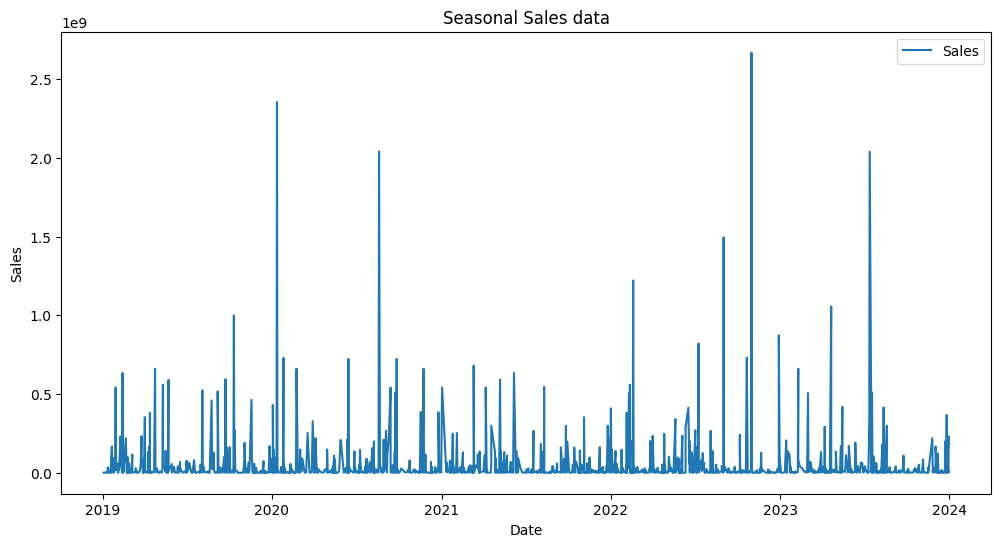

In [55]:
plt.figure(figsize=(12,6))
plt.plot(sales.index, sales['revenue_$'], label='Sales')
plt.title('Seasonal Sales data')
plt.xlabel('Date')
plt.ylabel('Sales')


plt.legend()
plt.show()

In [56]:
# Check for duplicate dates
duplicates = df4[df4.index.duplicated(keep=False)]
print(duplicates)

# Aggregate data by purchase_date to ensure each date is unique
df4 = df4.groupby(df4.index).sum()

               discounted_price_$  actual_price_$  discount_percentage_%  \
purchase_date                                                              
2023-08-07                 199.00          349.00                   43.0   
2022-05-14                 176.63          499.00                   65.0   
2020-03-05                 499.00          999.00                   50.0   
2019-12-14                 154.00          339.00                   55.0   
2019-01-25                 219.00          700.00                   69.0   
2020-01-03                 350.00          899.00                   61.0   
2019-05-31                 159.00          399.00                   60.0   
2021-03-07                 349.00          399.00                   13.0   
2022-07-05               13490.00        21990.00                   39.0   
2021-10-30                 970.00         1799.00                   46.0   
2022-06-26                 279.00          499.00                   44.0   
2022-07-09  

In [57]:
# Handle missing values
df4 = df4.asfreq('D')

df4['revenue_$'] = df4['revenue_$'].fillna(method='ffill') # forward fill the missing values it can also be backwards too
print(df4.isna().sum())

discounted_price_$       820
actual_price_$           820
discount_percentage_%    820
rating                   820
rating_count             820
revenue_$                  0
selling_price_$          820
sales_volume             820
price_change_%           820
quantity_change_%        820
PED                      832
dtype: int64


In [58]:
df4.info()

df4.to_csv('../data/cleaned/sales_amazon.csv',)

print('File successfully saved as a parquet with dimension: {df4.shape}')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1824 entries, 2019-01-03 to 2023-12-31
Freq: D
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   discounted_price_$     1004 non-null   float64
 1   actual_price_$         1004 non-null   float64
 2   discount_percentage_%  1004 non-null   float64
 3   rating                 1004 non-null   float64
 4   rating_count           1004 non-null   float64
 5   revenue_$              1824 non-null   float64
 6   selling_price_$        1004 non-null   float64
 7   sales_volume           1004 non-null   float64
 8   price_change_%         1004 non-null   float64
 9   quantity_change_%      1004 non-null   float64
 10  PED                    992 non-null    float64
dtypes: float64(11)
memory usage: 171.0 KB
File successfully saved as a parquet with dimension: {df4.shape}


In [59]:
# # I am doing this to save memory allocation

del df1,df2,cat_df, num_df, df_cleaned, df2_cleaned,

In [60]:
# Remove outliers

rolling_mean = df4['revenue_$'].rolling(window=7).mean()
rolling_std = df4['revenue_$'].rolling(window=7).std()

outlier = (df4['revenue_$'] - rolling_mean).abs() > 2 * rolling_std

df4['revenue_$'] = df4['revenue_$'].where(~outlier, rolling_mean)

In [61]:
# Differencing for stationarity - ARIMA model

df4['revenue_diff'] = df4['revenue_$'].diff()

df4.dropna(inplace=True)

print(f'Check for the sum of missing values \n {df4.isna().sum()} and check the dataset dimension {df4.shape}')

Check for the sum of missing values 
 discounted_price_$       0
actual_price_$           0
discount_percentage_%    0
rating                   0
rating_count             0
revenue_$                0
selling_price_$          0
sales_volume             0
price_change_%           0
quantity_change_%        0
PED                      0
revenue_diff             0
dtype: int64 and check the dataset dimension (991, 12)


**Model Development**

In [62]:
from statsmodels.tsa.stattools import adfuller 

time_series_data = df4['revenue_$']

adf_test = adfuller(time_series_data)

print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] > 0.05:
    print(f"Time series is non-stationary, Differencing needed")
else:
    print(f"Time series is stationary, no differencing needed")

ADF Statistic: -15.686805356459635
p-value: 1.4500609429768547e-28
Time series is stationary, no differencing needed


**Auto-Arima for Sales volume forecasting**

In [63]:
# Create a sales dataframe
sales = df4[["sales_volume", "revenue_$"]]

sales[:5]

,sales_volume,revenue_$
purchase_date,,
2019-01-02,13284.0,5646286.0
2019-01-04,9131.0,155646294.0
2019-01-05,28499.0,17468306.0
2019-01-06,12510.0,94072940.0
2019-01-07,6537.0,895569.0


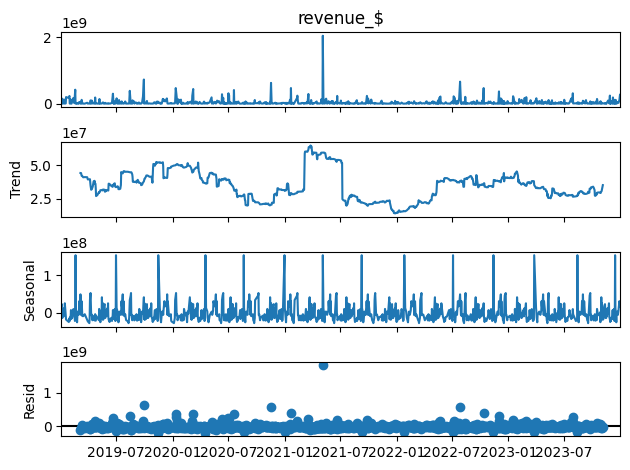

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(sales['revenue_$'], model='additive', period = 75)
decomposed.plot()
plt.show()

In [65]:
# Split the data into training and test sets

train_set = sales['revenue_$'][:-12] 
test_set = sales['revenue_$'][-12:] 

In [66]:
from pmdarima import auto_arima

aarima_model = auto_arima(train_set, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

print(aarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=39530.770, Time=1.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=39530.022, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=39524.307, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=39524.845, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=39661.288, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=39522.752, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=39524.263, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=39526.263, Time=0.50 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=39524.737, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=39524.756, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=39523.313, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=39526.739, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=39618.786, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 3.473 sec

In [67]:
aarima_result = aarima_model.fit(train_set)
aarima_result

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [68]:
# Make Prediction for Auto-arima
aarima_pred = aarima_model.predict(n_periods=12)

aarima_pred.round(2)[:5]

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


999     43317526.15
1000    36454240.46
1001    35795205.98
1002    35731923.40
1003    35725846.81
dtype: float64

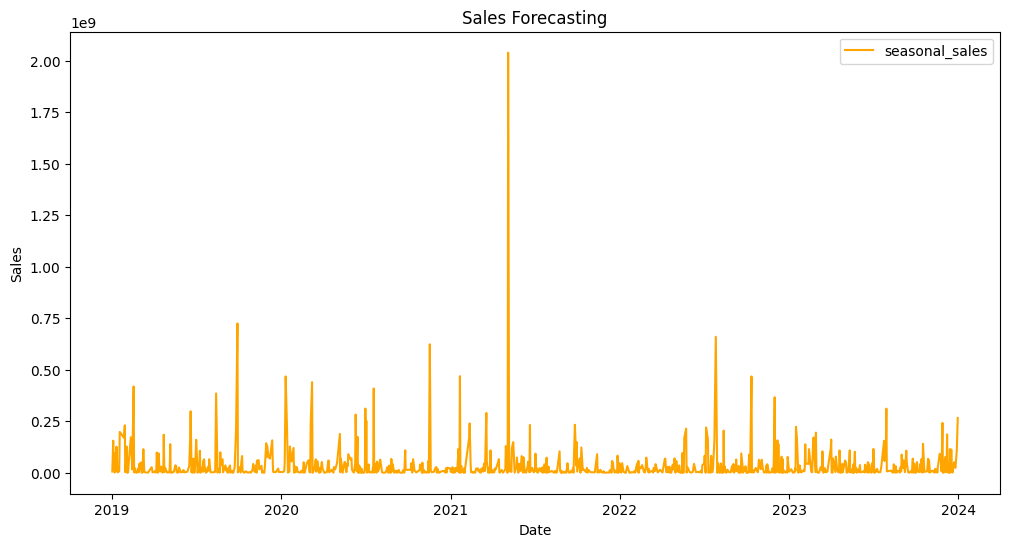

In [69]:
# Visualize forecasting

plt.figure(figsize=(12,6))
plt.plot(sales.index, sales['revenue_$'], label='seasonal_sales', color='orange')
plt.title('Sales Forecasting')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.legend()
plt.show()

Machine Learning objectives
Time series, Sales forecast analysis (LSTM)

**ARIMA Model**

In [70]:
# checking the value count in discounted price
print(f"{df4['discounted_price_$'].value_counts().sum()}")


# let's re-arrange the dataframe

price_col = [col for col in df4.columns if 'price' in col.lower()]

user_col = [col for col in df4.columns if 'user' in col.lower()]

product_col = [col for col in df4.columns if 'product' in col.lower()]

other_col = [col for col in df4.columns if col not in user_col + price_col + product_col]

new_col_ = user_col + price_col + product_col + other_col

df4 = df4[new_col_]

print(df4.columns)

1011
Index(['user_id', 'user_name', 'discounted_price_$', 'actual_price_$',
       'selling_price_$', 'price_change_%', 'product_id', 'product_name',
       'about_product', 'product_link', 'discount_percentage_%', 'rating',
       'rating_count', 'category', 'review_id', 'review_title',
       'review_content', 'img_link', 'revenue_$', 'sales_volume',
       'discount_bin', 'quantity_change_%', 'PED', 'revenue_diff'],
      dtype='object')


In [71]:
df4.head()

,user_id,user_name,discounted_price_$,actual_price_$,selling_price_$,price_change_%,product_id,product_name,about_product,product_link,discount_percentage_%,rating,rating_count,category,review_id,review_title,review_content,img_link,revenue_$,sales_volume,discount_bin,quantity_change_%,PED,revenue_diff
purchase_date,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,AFZIZOK5KDBOB5QCHUQRR2ZWUYKAAH77IQRYD54XCRMCO7...,A VaseNitesh singh,1088.0,2794.0,1706.0,-75.481852,B006LW0WDQB0B2DJ5RVQ,TCL 80 cm (32 inches) HD Ready Certified Andro...,Chromecast suporting Apps : NetflixUSB Type-C...,https://www.amazon.in/AmazonBasics-16-Gauge-Sp...,116.0,8.7,13284.0,CablesCables&Accessories,RDDDU5N0JHZS7R10PB68FRUHT5V,Super well build. Quality product worth the mo...,the OS has lags after about a year of use. Th...,https://m.media-amazon.com/images/W/WEBP_40237...,5646286.0,13284.0,40-50%60-70%,990.888750,-640.634240,5590012.0
2019-01-04,AFM5JL37WY7G6MLQUI4WAXUJME7QAFI3EFAYZRL5L5TQXR...,Jithindasjaswant saiabhijit,33896.0,52938.0,19042.0,525.745591,B0B1YZX72FB0BHVPTM2CB07Z51CGGH,OnePlus 80 cm (32 inches) Y Series HD Ready LE...,iPad mini and iPad Air 178 Degree wide viewin...,https://www.amazon.in/Acer-inches-Ultra-Androi...,157.0,12.1,9131.0,Accessories&PeripheralsCables&AccessoriesElect...,R175VFSB2A32HGRLQPU8GARVD9AR2C462047AF3K7,Good productAs good as originalUseful,Good product if it produces a decent pictureCa...,https://m.media-amazon.com/images/W/WEBP_40237...,155646294.0,9131.0,30-40%70-80%40-50%,39337.245922,109.286804,150000008.0
2019-01-05,AHOJBIZVVIIFJKRREY4B6ESVA4KAAEKMVX2VDNNX4ZFXI6...,CustomerVipin ThakurKhaja moin,1952.0,3468.0,1516.0,209.139709,B09JS562TPB08CF3D7QRB07Z3K96FR,Moto G6 G7 (0.25M 480Mbps Data Sync Model: CB...,Colour Space Mapping Disney + HotstarSpecial...,https://www.amazon.in/Motorola-keypad-Mobile-E...,142.0,12.4,28499.0,WirelessUSBAdaptersAccessories&PeripheralsAcce...,R1S5F9QI0M1VBZR5RP542IMC4OIR6IPR9FHZ5BOT,Good productGood ProductAcer Television Review,-Slow charging4500amh battery18 watt Charger4 ...,https://m.media-amazon.com/images/I/41MOWVL2YN...,17468306.0,28499.0,10-20%50-60%70-80%,384.775045,12.615579,-138177988.0
2019-01-06,AGVIAQK2HQ47P7UVXHW2NBAEU7YQAECGAMNNIMW5QOPOBX...,gunasekaran desomayananamAjinkyaMohammed irfan,20247.0,28389.0,8142.0,504.699720,B09BW334MLB0BC9BW512B07BKSSDR2,TabletAcer 127 cm (50 inches) I Series 4K Ult...,5000+ times connect & disconnect to ensure th...,https://www.amazon.in/Dealfreez-Compatible-Sil...,154.0,12.6,12510.0,Computers&AccessoriesElectronicsComputers&Acce...,REVSR0ILY3547R2JTBG4GO7WPMGR17CVFA9I53GML,Works wellMaine ₹99 me liya hai offer me or ye...,also depends on your modem or cellular connec...,https://m.media-amazon.com/images/I/41pA1xo-mI...,94072940.0,12510.0,70-80%20-30%50-60%,2444.941534,inf,76604634.0
2019-01-07,AHUVYZMQ6PWI54UXP7SLLS4ZU46A,Manuj Patel,137.0,160.0,23.0,-96.799360,B00LZLPYHW,Optical,high in tensile strength,https://www.amazon.in/Classmate-Premium-Subjec...,14.0,4.4,6537.0,Electronics,R294UWCBOTKD8H,Everything thing good except the installation ...,Supports fast charging for all my Samsung phon...,https://m.media-amazon.com/images/W/WEBP_40237...,895569.0,6537.0,10-20%,-13.657377,0.141090,-93177371.0


In [72]:
# 1. Set up ARIMA, fit the model with the data and print the model summary

# Import the necessary library
from pmdarima import auto_arima
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# "create the timeseries data
time_series_data = df4['revenue_$']

# ARIMA Model development, where (p=1, d=0, q=1 are the starting point, thus adjust as needed)
arima_model = ARIMA(time_series_data, order=(1,1,1))
arima_result = arima_model.fit()


# Print model output summary
print(arima_result.summary())


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              revenue_$   No. Observations:                 1011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -19988.888
Date:                Sat, 21 Dec 2024   AIC                          39983.777
Time:                        19:34:39   BIC                          39998.530
Sample:                             0   HQIC                         39989.381
                               - 1011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0980      0.029      3.364      0.001       0.041       0.155
ma.L1         -0.9985      0.004   -225.788      0.000      -1.007      -0.990
sigma2      1.101e+16   2.72e-19   4.05e+34      0.0

In [73]:
# 2. Make predictions on the test set

# Define start and end for test set predictions using 40% training, 60% testing
train_size = int(len(time_series_data) * 0.65)  
start = train_size  
end = len(time_series_data) - 1  

# Generate predictions for the test period
arima_pred = arima_result.predict(start=start, end=end, typ='levels')

# Separate the actual test values for evaluation
y_test_arima = time_series_data[start:]


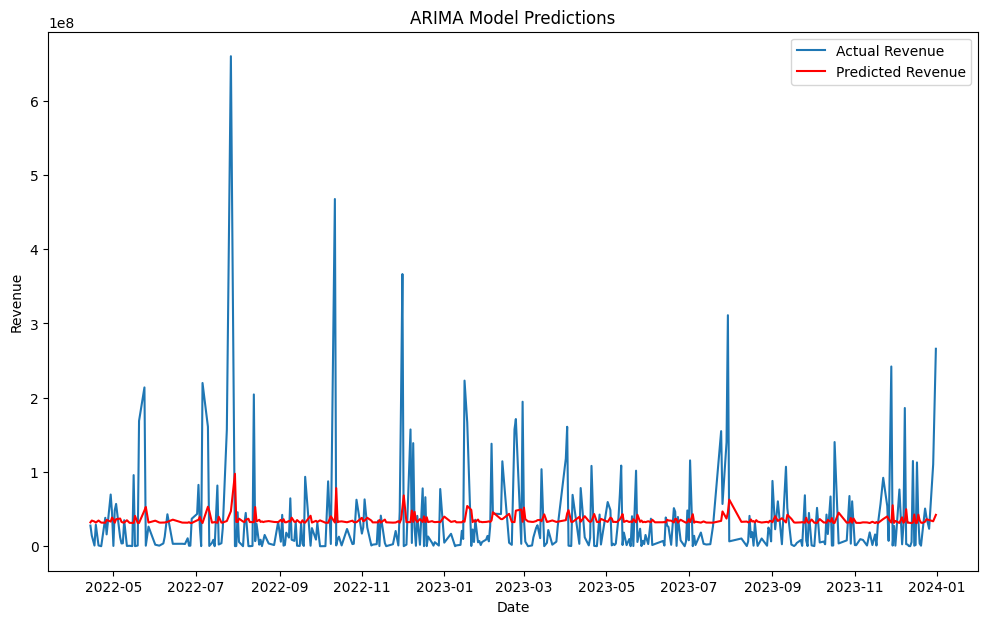

In [74]:
# 3. Plot actual and predicted values

plt.figure(figsize=(12,7))
plt.plot(time_series_data[start:], label='Actual Revenue')
plt.plot(arima_pred, color='red', label='Predicted Revenue')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


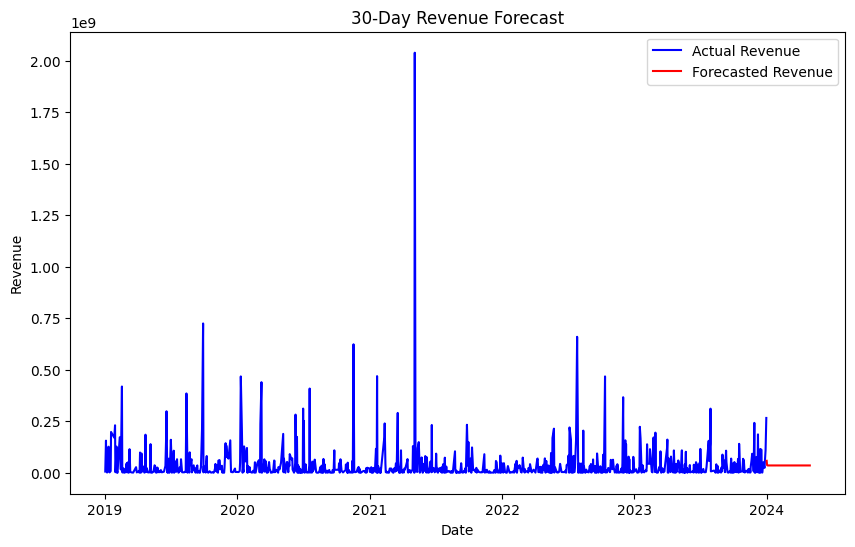

In [75]:
# 4. Forecast with the ARIMA model trained for the next 30 days
arima_forecast = arima_result.forecast(steps=120)
arima_forecast.round(3)

# date range for the forecast
forecast_index = pd.date_range(start=time_series_data.index[-1] + pd.Timedelta(days=1), periods=120, freq='D')

# Plot the actual revenue data
plt.figure(figsize=(10, 6))
plt.plot(time_series_data, label='Actual Revenue', color='blue')

# plot for the forecasted revenue data with the generated date range
plt.plot(forecast_index, arima_forecast, color='red', label='Forecasted Revenue')
plt.title('30-Day Revenue Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

In [76]:
# USING PLOTLY TO VISUALIZE THE FORECAST

import plotly.graph_objects as go

# Plotly figure
fig = go.Figure()

# Trace the actual revenue 
fig.add_trace(go.Scatter(
    x=time_series_data.index, 
    y=time_series_data.values, 
    mode='lines', 
    name='Actual Revenue',
    line=dict(color='blue')
))

# Trace the forecasted revenue 
fig.add_trace(go.Scatter(
    x=forecast_index, 
    y=arima_forecast, 
    mode='lines', 
    name='Forecasted Revenue',
    line=dict(color='red', dash='dash')
))

# Layout
fig.update_layout(
    title='30-Day Revenue Forecast',
    xaxis_title='Date',
    yaxis_title='Revenue',
    legend=dict(x=0.01, y=0.99),  
    width=800,
    height=500
)

fig.show()


**Timeseries model performance report**

In [77]:
# 5. Evaluation of model

# ARIMA model evaluation
arima_mse = mean_squared_error(y_test_arima, arima_pred)
arima_mae = mean_absolute_error(y_test_arima, arima_pred)
arima_r2 = r2_score(y_test_arima, arima_pred)
arima_rmse = np.sqrt(arima_mse)
arima_mape = np.mean(np.abs((y_test_arima - arima_pred)/ y_test_arima)) * 100

# Auto-Arima Model Evaluation
aarima_mae = mean_absolute_error(test_set, aarima_pred)
aarima_mse = mean_squared_error(test_set, aarima_pred)
aarima_rmse = np.sqrt(aarima_mse)
aarima_mape = np.mean(np.abs((test_set - aarima_pred) / test_set)) * 100
aarima_r2 = r2_score(test_set, aarima_pred)

# Prepare a dataframe to show the used metrics
list_r2 = [arima_r2, aarima_r2]
list_mae = [arima_mae, aarima_mae]
list_mse = [arima_mse, aarima_mse]
list_rmse = [arima_rmse, aarima_rmse]
list_mape = [arima_mape,aarima_mape ]

Report = pd.DataFrame(list_r2, index=["ARIMA", "AUTO-ARIMA"])
Report.columns = ['R2 Score']
Report.insert(loc=1, column='Mean Absolute Error', value=list_mae)
Report.insert(loc=2, column='Mean Squared Error', value=list_mse)
Report.insert(loc=3, column='Root Mean Squared Error', value=list_rmse)
#Report.insert(loc=4, column='Mape', value=list_mape)
Report.columns.name = 'Algorithm'

print(Report.round(4))

Algorithm   R2 Score  Mean Absolute Error  Mean Squared Error  \
ARIMA         0.0090         3.956858e+07        4.398551e+15   
AUTO-ARIMA   -0.0796         4.790568e+07        5.871972e+15   

Algorithm   Root Mean Squared Error  
ARIMA                  6.632157e+07  
AUTO-ARIMA             7.662879e+07  


**Deep learning model**

In [63]:

# Added time-based features
df4['month'] = df4.index.month
df4['day_of_week'] = df4.index.dayofweek
df4['quarter'] = df4.index.quarter

# Categorical variables encoding
df4 = pd.get_dummies(df4, columns=['month','day_of_week','quarter'], drop_first=True)

In [66]:
# Scaling the Data (for LSTM)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Use revenue_$ data for scaling
df4['revenue_scaled'] = scaler.fit_transform(df4[['revenue_$']])  

df4[:5]


,discounted_price_$,actual_price_$,discount_percentage_%,rating,rating_count,revenue_$,selling_price_$,sales_volume,price_change_%,quantity_change_%,PED,revenue_diff,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_2,quarter_3,quarter_4,revenue_scaled
purchase_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-05,159.0,399.0,60.0,4.1,4768.0,7.581120e+05,240.0,4768.0,-55.617353,-94.987174,1.707869,2.048690e+05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.001047
2019-01-08,9499.0,11999.0,21.0,4.2,284.0,2.697716e+06,2500.0,284.0,566.611111,-99.577752,-0.175743,1.939604e+06,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.003732
2019-01-09,199.0,999.0,80.0,4.3,87.0,1.731300e+04,800.0,87.0,0.000000,-46.625767,-inf,-2.680403e+06,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000022
2019-01-12,1588.0,3600.0,113.0,8.2,69542.0,5.467765e+06,2012.0,69542.0,240.574130,24285.340467,242.328484,5.450452e+06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.007566
2019-01-15,547.0,2999.0,82.0,4.3,407.0,2.226290e+05,2452.0,407.0,501.002004,-48.415716,-0.096638,-3.378585e+07,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.000306


In [67]:

# Create the lag features
df4['revenue_lag_1'] = df4['revenue_scaled'].shift(1)
df4['revenue_lag_2'] = df4['revenue_scaled'].shift(2)

# generate the rolling statistics 
df4['revenue_rolling_mean'] = df4['revenue_scaled'].rolling(window=7).mean()
df4['revenue_rolling_std'] = df4['revenue_scaled'].rolling(window=7).std()

# Drop any rows with NaN values
df4.dropna(inplace=True)

In [68]:
# Define a time step
time_steps = 15

# Creating a sequence and target
X,y = [],[]
for i in range(time_steps, len(df4)):
    X.append(df4['revenue_scaled'].values[i - time_steps:i])
    y.append(df4['revenue_scaled'].values[i])
    
# convert the X & y to array 
X,y = np.array(X), np.array(y)


In [69]:
# Train-test split
split_index = int(0.70 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [70]:
# Scale feature
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# scale features
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.fit_transform(X_test)

#scale target
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_scaled = scaler_y.fit_transform(y_test.reshape(-1,1))

# Reshape X for LSTM input (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 15, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 15, 1))

**Long Short Term Memory Neural Network**

In [ ]:
# Build and Compile the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


# Build the LSTM Model
model = Sequential()
model.add(LSTM(units=124, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(LSTM(units=32, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))

model.add(Dense(units=1))

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Print Model Summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 15, 100)           40800     
                                                                 
 dropout_3 (Dropout)         (None, 15, 100)           0         
                                                                 
 lstm_4 (LSTM)               (None, 15, 50)            30200     
                                                                 
 dropout_4 (Dropout)         (None, 15, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 25)                7600      
                                                                 
 dropout_5 (Dropout)         (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [73]:
# Train the LSTM model
history = model.fit(X_train, y_train, epochs=80, batch_size=64, validation_split=0.2 , verbose=1)


Epoch 1/80
9/9 [==============================] - 20s 256ms/step - loss: 2.0325 - mae: 0.0475 - val_loss: 2.0155 - val_mae: 0.0519
Epoch 2/80
9/9 [==============================] - 0s 18ms/step - loss: 1.9967 - mae: 0.0497 - val_loss: 1.9802 - val_mae: 0.0565
Epoch 3/80
9/9 [==============================] - 0s 19ms/step - loss: 1.9623 - mae: 0.0552 - val_loss: 1.9461 - val_mae: 0.0621
Epoch 4/80
9/9 [==============================] - 0s 20ms/step - loss: 1.9286 - mae: 0.0587 - val_loss: 1.9127 - val_mae: 0.0642
Epoch 5/80
9/9 [==============================] - 0s 18ms/step - loss: 1.8954 - mae: 0.0587 - val_loss: 1.8799 - val_mae: 0.0630
Epoch 6/80
9/9 [==============================] - 0s 17ms/step - loss: 1.8629 - mae: 0.0572 - val_loss: 1.8478 - val_mae: 0.0613
Epoch 7/80
9/9 [==============================] - 0s 16ms/step - loss: 1.8311 - mae: 0.0576 - val_loss: 1.8161 - val_mae: 0.0604
Epoch 8/80
9/9 [==============================] - 0s 19ms/step - loss: 1.7995 - mae: 0.0559 - v

In [74]:
# Predict on test set
y_pred = model.predict(X_test)

y_pred[:5]

10/10 [==============================] - 1s 11ms/step


array([[0.05000576],
       [0.04992493],
       [0.04984545],
       [0.0497636 ],
       [0.04968442]], dtype=float32)

In [75]:
#Evaluate the model on the test dataset
loss, mae = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss}, Test MAE: {mae}")

10/10 [==============================] - 0s 11ms/step - loss: 0.4836 - mae: 0.0537
Test Loss: 0.48364362120628357, Test MAE: 0.05370417237281799


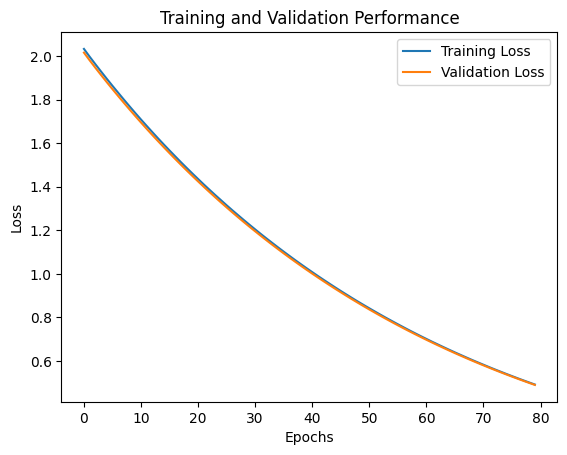

In [76]:
# plotting for training and validation comparison
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


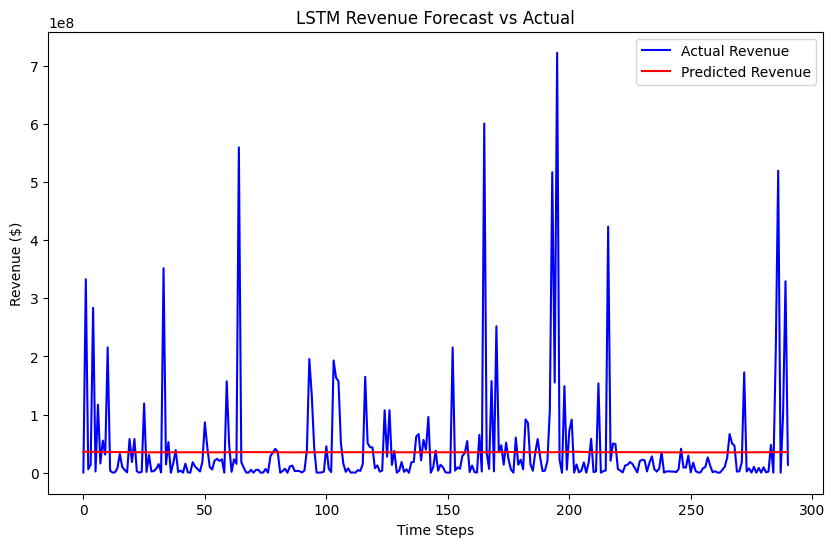

In [78]:



# Inverse transform predictions and test values back to original scale
y_test_unscaled = scaler.inverse_transform(y_test_scaled)  
y_pred_unscaled = scaler.inverse_transform(y_pred)  


# Plot actual vs predicted revenue
plt.figure(figsize=(10, 6))
plt.plot(y_test_unscaled, color='blue', label='Actual Revenue')
plt.plot(y_pred_unscaled, color='red', label='Predicted Revenue')
plt.title('LSTM Revenue Forecast vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()



1/1 [==============================] - 0s 23ms/step


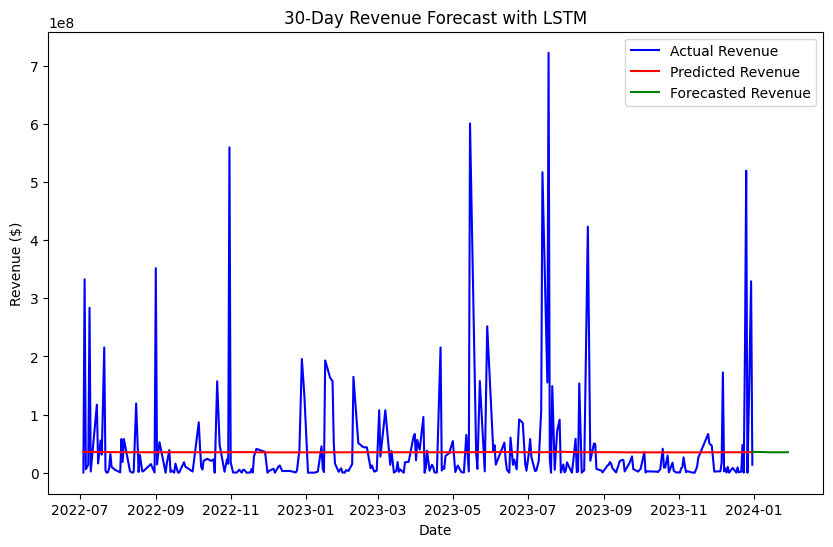

In [79]:
# Forecast the next 30 days
forecast_steps = 30
forecast = []

# Use the last available sequence from the test data
last_sequence = X_test[-1]

for _ in range(forecast_steps):
    next_step_scaled = model.predict(last_sequence.reshape(1, time_steps, 1))
    forecast.append(next_step_scaled[0, 0])
    
    # Update last sequence with the predicted value and remove the oldest value
    last_sequence = np.append(last_sequence[1:], next_step_scaled, axis=0)

# Inverse transform the forecasted values
forecast_unscaled = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot forecasted future revenue
plt.figure(figsize=(10, 6))
plt.plot(df4.index[-len(y_test):], y_test_unscaled, label='Actual Revenue', color='blue')
plt.plot(df4.index[-len(y_test):], y_pred_unscaled, label='Predicted Revenue', color='red')
plt.plot(pd.date_range(df4.index[-1], periods=forecast_steps, freq='D'), forecast_unscaled, label='Forecasted Revenue', color='green')
plt.title('30-Day Revenue Forecast with LSTM')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()


**Multilayer Perceptron (MLP) Neural Networks - Feedforward Neural Network**

In [80]:
# Reshape the data into 2D

X_train_flat = X_train.reshape(X_train.shape[0],-1) 
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"X_test_flat shape: {X_test_flat.shape} and X_train_flat shape: {X_train_flat.shape}")

X_test_flat shape: (291, 15) and X_train_flat shape: (679, 15)


In [82]:
# Build and Compile the MLP Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define MLP Model
mlp_model = Sequential()
mlp_model.add(Dense(units=128, activation='relu', input_shape=(X_train_flat.shape[1],)))
mlp_model.add(Dense(units=64, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(units=32, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(units=16, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(units=1, activation='linear'))  

# Compile the model
mlp_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print Model Summary
mlp_model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               2048      
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dropout_10 (Dropout)        (None, 16)               

In [83]:
# Train the MLP model

history = mlp_model.fit( X_train_flat, y_train_scaled, epochs=80, batch_size=64, validation_split=0.2, verbose=1)


Epoch 1/80
9/9 [==============================] - 1s 30ms/step - loss: 0.0127 - mae: 0.0599 - val_loss: 0.0151 - val_mae: 0.0619
Epoch 2/80
9/9 [==============================] - 0s 11ms/step - loss: 0.0118 - mae: 0.0584 - val_loss: 0.0152 - val_mae: 0.0607
Epoch 3/80
9/9 [==============================] - 0s 10ms/step - loss: 0.0118 - mae: 0.0567 - val_loss: 0.0152 - val_mae: 0.0600
Epoch 4/80
9/9 [==============================] - 0s 10ms/step - loss: 0.0112 - mae: 0.0571 - val_loss: 0.0152 - val_mae: 0.0639
Epoch 5/80
9/9 [==============================] - 0s 12ms/step - loss: 0.0112 - mae: 0.0583 - val_loss: 0.0151 - val_mae: 0.0628
Epoch 6/80
9/9 [==============================] - 0s 10ms/step - loss: 0.0111 - mae: 0.0574 - val_loss: 0.0151 - val_mae: 0.0604
Epoch 7/80
9/9 [==============================] - 0s 10ms/step - loss: 0.0111 - mae: 0.0548 - val_loss: 0.0151 - val_mae: 0.0593
Epoch 8/80
9/9 [==============================] - 0s 11ms/step - loss: 0.0110 - mae: 0.0550 - val

In [84]:
# Predict on test set
y_pred_scaled = mlp_model.predict(X_test_flat)

# Inverse transform predictions and test values
y_test_unscaled = scaler_y.inverse_transform(y_test_scaled)
y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled)

# Calculate metrics
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")

10/10 [==============================] - 0s 3ms/step


NameError: name 'mean_squared_error' is not defined

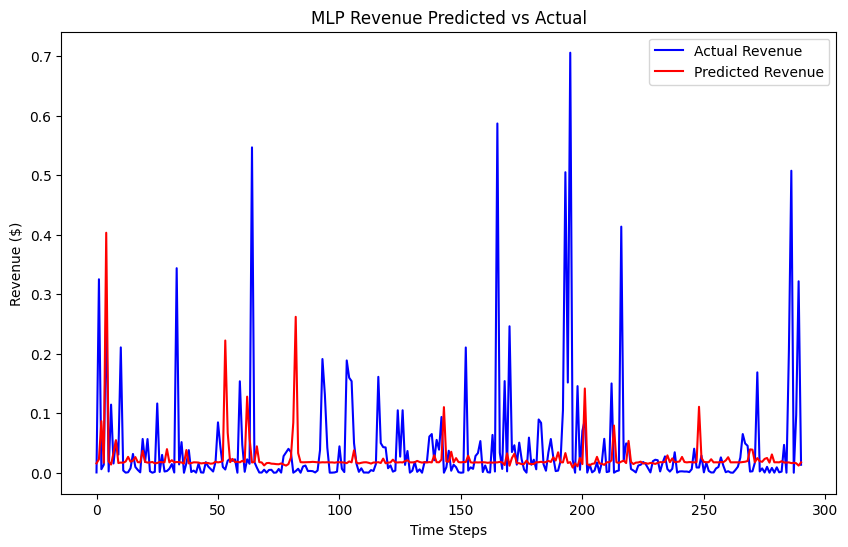

In [85]:
# Plot actual vs predicted revenue
plt.figure(figsize=(10, 6))
plt.plot(y_test_unscaled, label='Actual Revenue', color='blue')
plt.plot(y_pred_unscaled, label='Predicted Revenue', color='red')
plt.title('MLP Revenue Predicted vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()


1/1 [==============================] - 0s 25ms/step


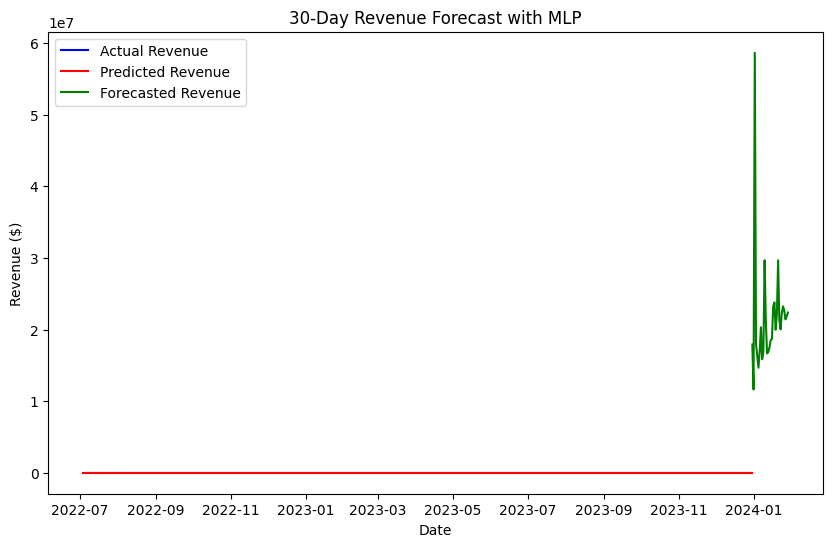

In [86]:
# Forecast the next 30 days
forecast_steps = 30
forecast = []

# Use the last available sequence from the test data
last_sequence = X_test_flat[-1]

for _ in range(forecast_steps):
    next_step_scaled = mlp_model.predict(last_sequence.reshape(1, -1))
    forecast.append(next_step_scaled[0, 0])
    
    # Update last sequence with the predicted value and remove the oldest value
    last_sequence = np.append(last_sequence[1:], next_step_scaled).reshape(-1)

# Inverse transform the forecasted values
forecast_unscaled = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot forecasted future revenue
plt.figure(figsize=(10, 6))
plt.plot(df4.index[-len(y_test):], y_test_unscaled, label='Actual Revenue', color='blue')
plt.plot(df4.index[-len(y_test):], y_pred_unscaled, label='Predicted Revenue', color='red')
plt.plot(pd.date_range(df4.index[-1], periods=forecast_steps, freq='D'), forecast_unscaled, label='Forecasted Revenue', color='green')
plt.title('30-Day Revenue Forecast with MLP')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()



Training with batch size: 16

Training with batch size: 32

Training with batch size: 64

Training with batch size: 128


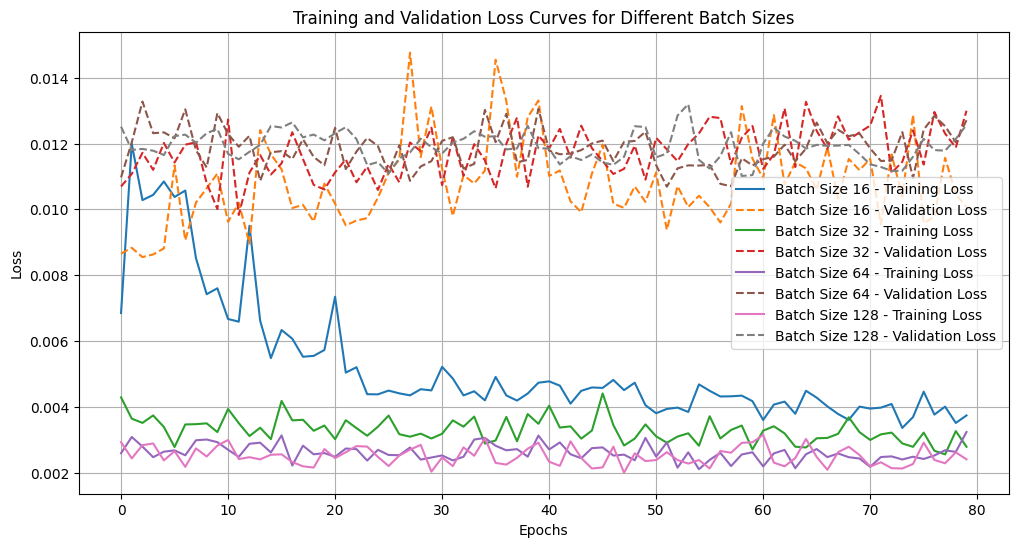

In [87]:
# Training curve analysis

# Define different batch sizes to test
batch_sizes = [16, 32, 64, 128]
results = {}

# To store loss curves
training_loss_curves = {}
validation_loss_curves = {}

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")
    
    # Train the model
    history = mlp_model.fit(
        X_train_flat, y_train,
        validation_data=(X_test_flat, y_test),
        epochs=80,
        batch_size=batch_size,  
        verbose=0  # Suppress verbose
    )
    
    # Store the loss curves
    training_loss_curves[batch_size] = history.history['loss']
    validation_loss_curves[batch_size] = history.history['val_loss']

# Plot training loss curves for different batch sizes
plt.figure(figsize=(12, 6))

for batch_size in batch_sizes:
    plt.plot(training_loss_curves[batch_size], label=f"Batch Size {batch_size} - Training Loss")
    plt.plot(validation_loss_curves[batch_size], linestyle='--', label=f"Batch Size {batch_size} - Validation Loss")

plt.title("Training and Validation Loss Curves for Different Batch Sizes")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

    

**General Insights**\
Smaller batch sizes (`16 and 32`) allow the model to respond quickly to patterns in the data but introduce instability in gradient updates, leading to fluctuations in loss curves.\
Larger batch sizes (`64 and 128`) provide smoother and more stable convergence, but they may slow down learning and fail to capture subtle data nuances.

**Recommendation**
Based on the plot, `batch size 64` appears to provide the best trade-off between stability and convergence speed.
If faster convergence is critical, consider using batch size 32 but compensate for the added instability by adjusting the learning rate or increasing regularization.

**Deep-learning models performance report**